In [1]:
import pickle
import numpy as np
from multigraph import MultiGraph

with open('adj_graph.pkl', 'rb') as inobj:
    op_graph = pickle.load(inobj)

a_graph = op_graph.get_adjacency_matrix()

In [11]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation
#load the saved embeddings
# load json and create model
json_file = open('aws_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("aws_model.h5")
print("Loaded model from disk")

Using Theano backend.


Loaded model from disk


In [12]:
model.compile(optimizer='adam', loss='mse')
embedding = model.predict(a_graph)

In [3]:
# Each node in the AIFB dataset is either a person, a project, a publication, a group, etc.
# Here we get a list of all of the nodes that have a certain label and put them in a dictionary
import re
publications = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Publikationen\/viewPublikationOWL\/id[0-9]*instance)>")
authors = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Personen\/viewPersonOWL\/id[0-9]*instance)>")
groups = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Forschungsgruppen\/viewForschungsgruppeOWL\/id[0-9]*instance)>")
projects = re.compile("<(http:\/\/www\.aifb\.uni-karlsruhe\.de\/Projekte\/viewProjektOWL\/id[0-9]*instance)>")

regex_dict = {"publications":publications, "authors":authors, 
              "groups":groups, "projects": projects}

from collections import defaultdict
categories = defaultdict(set)

In [5]:
with open("aifb_csv/aifb_stripped.nt") as f:
    for line in f:
        for k,reg in regex_dict.iteritems():
            finds = reg.match(line)
            if finds != None:
                categories[k].add(finds.group(1))

for k,v in categories.iteritems():
    print(k,len(v))

('groups', 5)
('publications', 1232)
('projects', 78)
('authors', 237)


In [69]:
import random
#get the embeddings for 100 instances from each category
subset_embeddings = []
subset_labels = []
label_enum = list(enumerate(categories.keys(),1))
label_dict = {j: i for i,j in label_enum}

for k,v in categories.iteritems():
    samples = random.sample(v, min(len(v), 100))
    for s in samples:
        #print(s,embedding[op_graph.nodes[s]])
        subset_embeddings.append(embedding[op_graph.nodes[s]])
        subset_labels.append(label_dict[k])
print(label_enum)

[(1, 'groups'), (2, 'publications'), (3, 'projects'), (4, 'authors')]


In [86]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gensim


#from https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
def tsnescatterplot(vectors, vector_labels, labels):
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # display scatter plot   
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=[cmap(norm(i)) for i in vector_labels])
    #draw the legend
    patches = []
    for l in labels:
        patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
    plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8

    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

def pcascatterplot(vectors, vector_labels, labels):
            
    # find tsne coords for 2 dimensions
    pca = PCA(n_components=2)
    np.set_printoptions(suppress=True)
    Y = pca.fit_transform(vectors)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    cmap = plt.cm.rainbow
    norm = mcolors.Normalize(vmin=0, vmax=len(labels))
    # display scatter plot
    plt.figure(figsize=(8,6),dpi=200)
    plt.scatter(x_coords, y_coords, c=[cmap(norm(i)) for i in vector_labels])
    
   #draw the legend
    patches = []
    for l in labels:
        patches.append(mpatches.Patch(color=cmap(norm(l[0])), label=l[1]))
        plt.legend(handles=patches)
    #scatterpoints=1, loc='lower left', ncol=3, fontsize=8
    
    #for label, x, y in zip(vector_labels, x_coords, y_coords):
    #    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

(1, 'groups')
(2, 'publications')
(3, 'projects')
(4, 'authors')


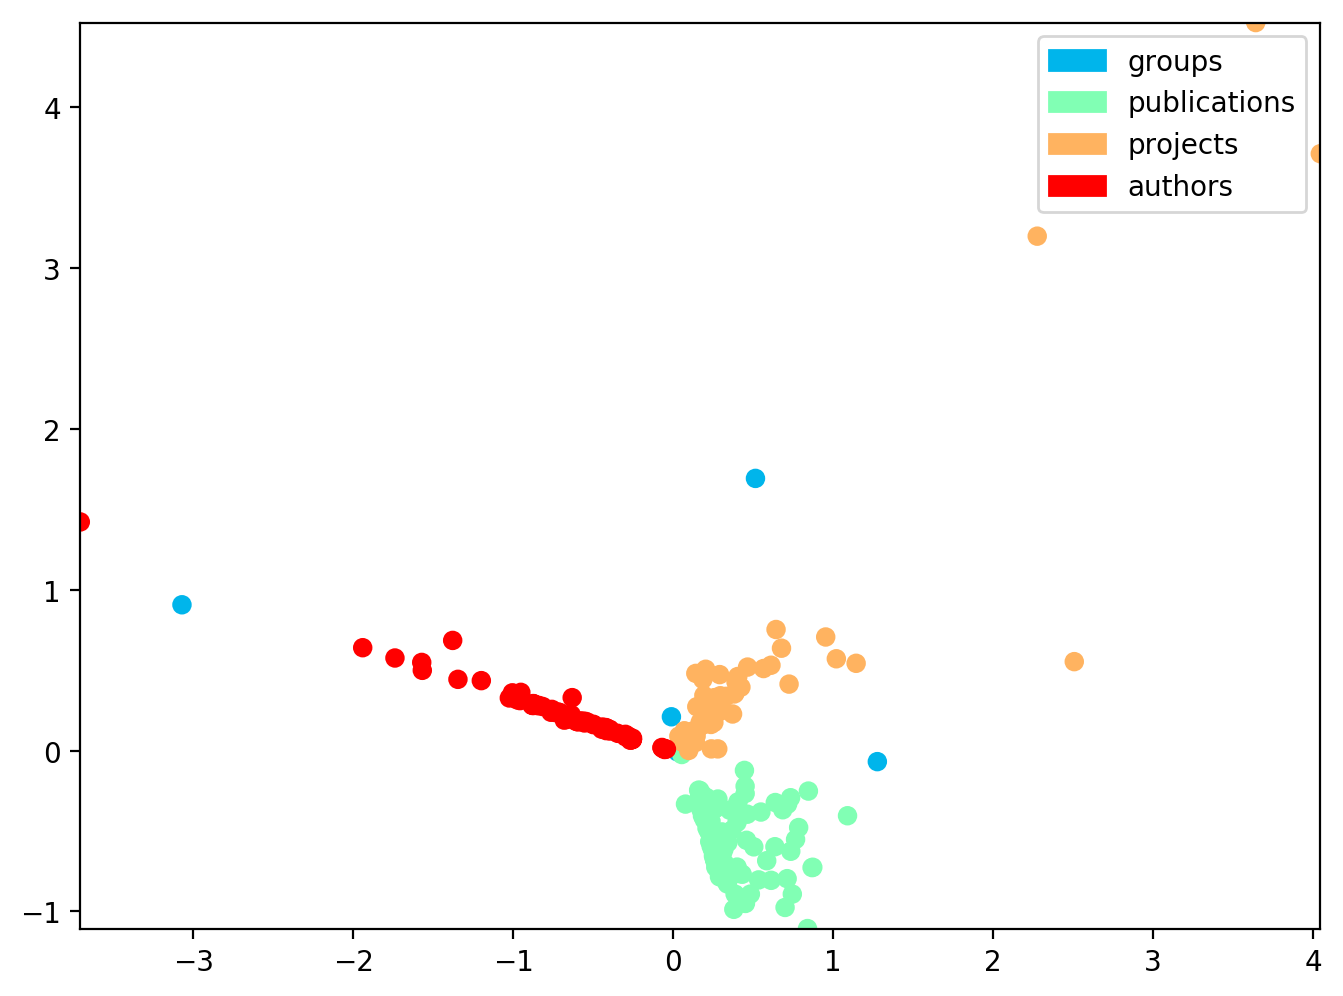

In [87]:
pcascatterplot(subset_embeddings, subset_labels, label_enum)

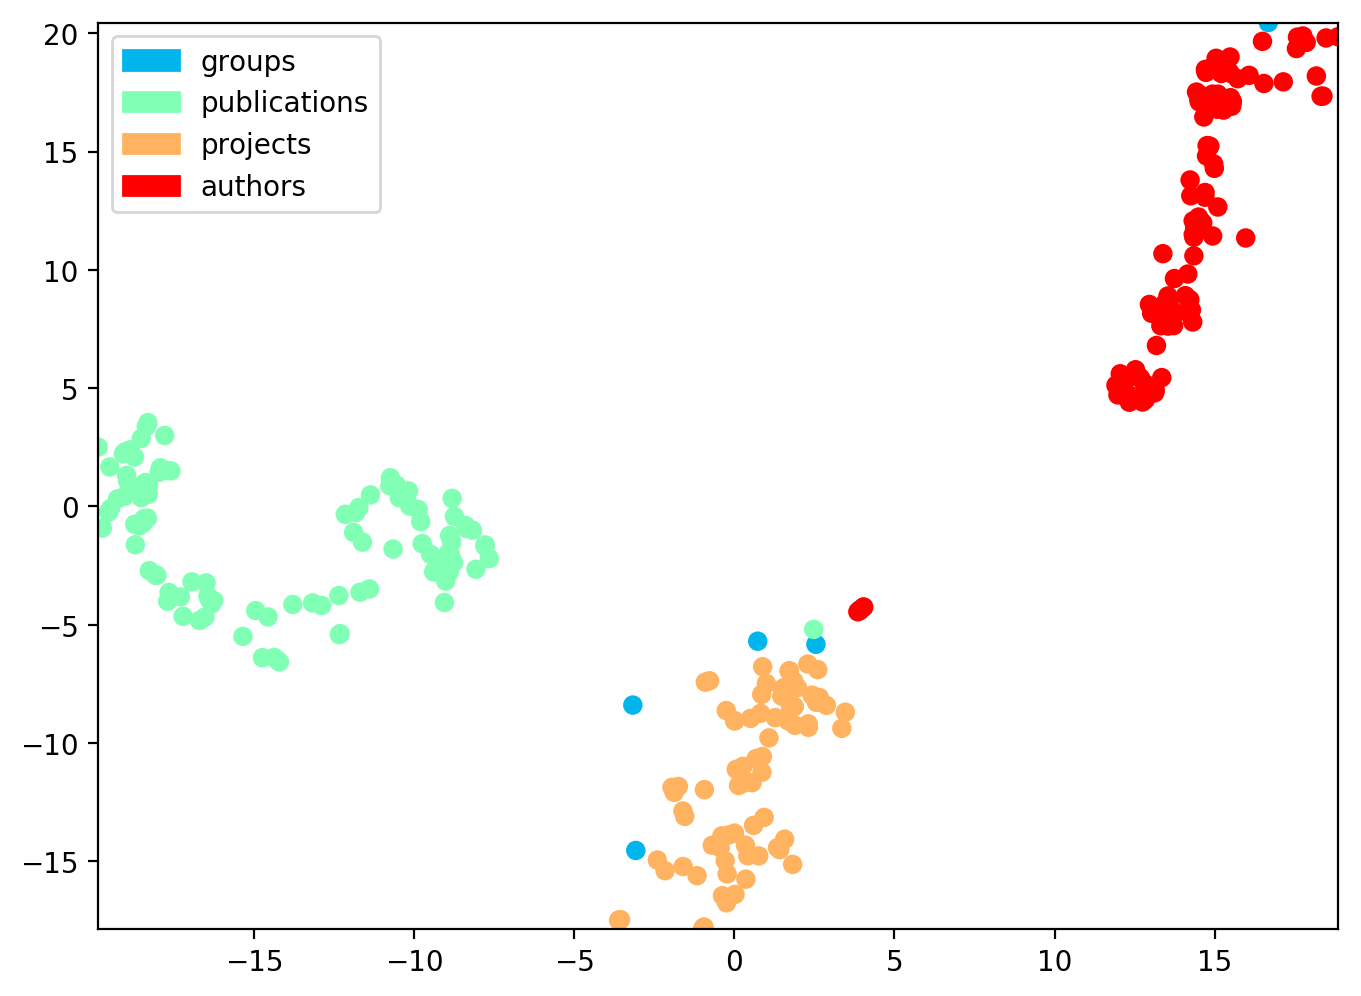

In [89]:
tsnescatterplot(subset_embeddings, subset_labels, label_enum)

In [96]:
import unicodecsv as csv
# The AIFB dataset has 176 people and they are associated with one of four affiliations in the organization.
# The completeSet.tsv file gives the URIs of the people and their affiliation
# (number, person, affiliation)
person_dict = defaultdict(list)
with open('aifb_csv/completeDataset.tsv', 'r') as csvfile:
    graphreader = csv.reader(csvfile, delimiter="\t")
    i = 0
    for row in graphreader:
        if i == 0:
            i += 1
            continue
        person_dict[row[2].rsplit('/',2)[-1]].append(row[1])

for k,v in person_dict.iteritems():
    print(k,len(v))

(u'id4instance', 15)
(u'id3instance', 60)
(u'id2instance', 28)
(u'id1instance', 73)


In [97]:
#get the embeddings for each of the people
subset_embeddings = []
subset_labels = []
label_enum = list(enumerate(person_dict.keys(),1))
label_dict = {j: i for i,j in label_enum}

for k,v in person_dict.iteritems():
    for s in v:
        #print(s,embedding[op_graph.nodes[s]])
        subset_embeddings.append(embedding[op_graph.nodes[s]])
        subset_labels.append(label_dict[k])
print(label_enum)

[(1, u'id4instance'), (2, u'id3instance'), (3, u'id2instance'), (4, u'id1instance')]


(1, u'id4instance')
(2, u'id3instance')
(3, u'id2instance')
(4, u'id1instance')


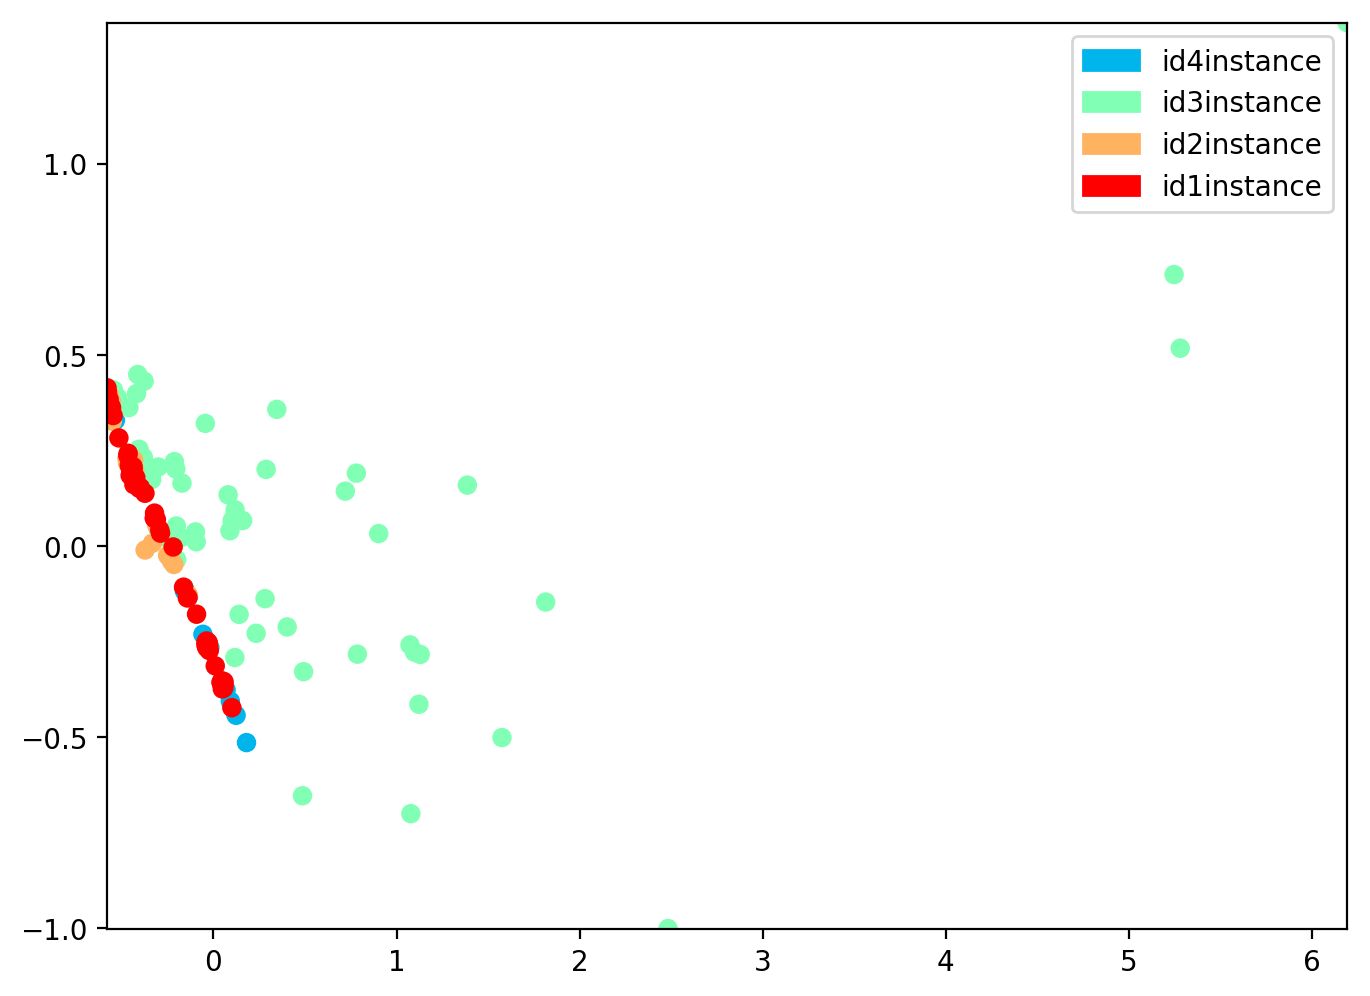

In [98]:
pcascatterplot(subset_embeddings, subset_labels, label_enum)

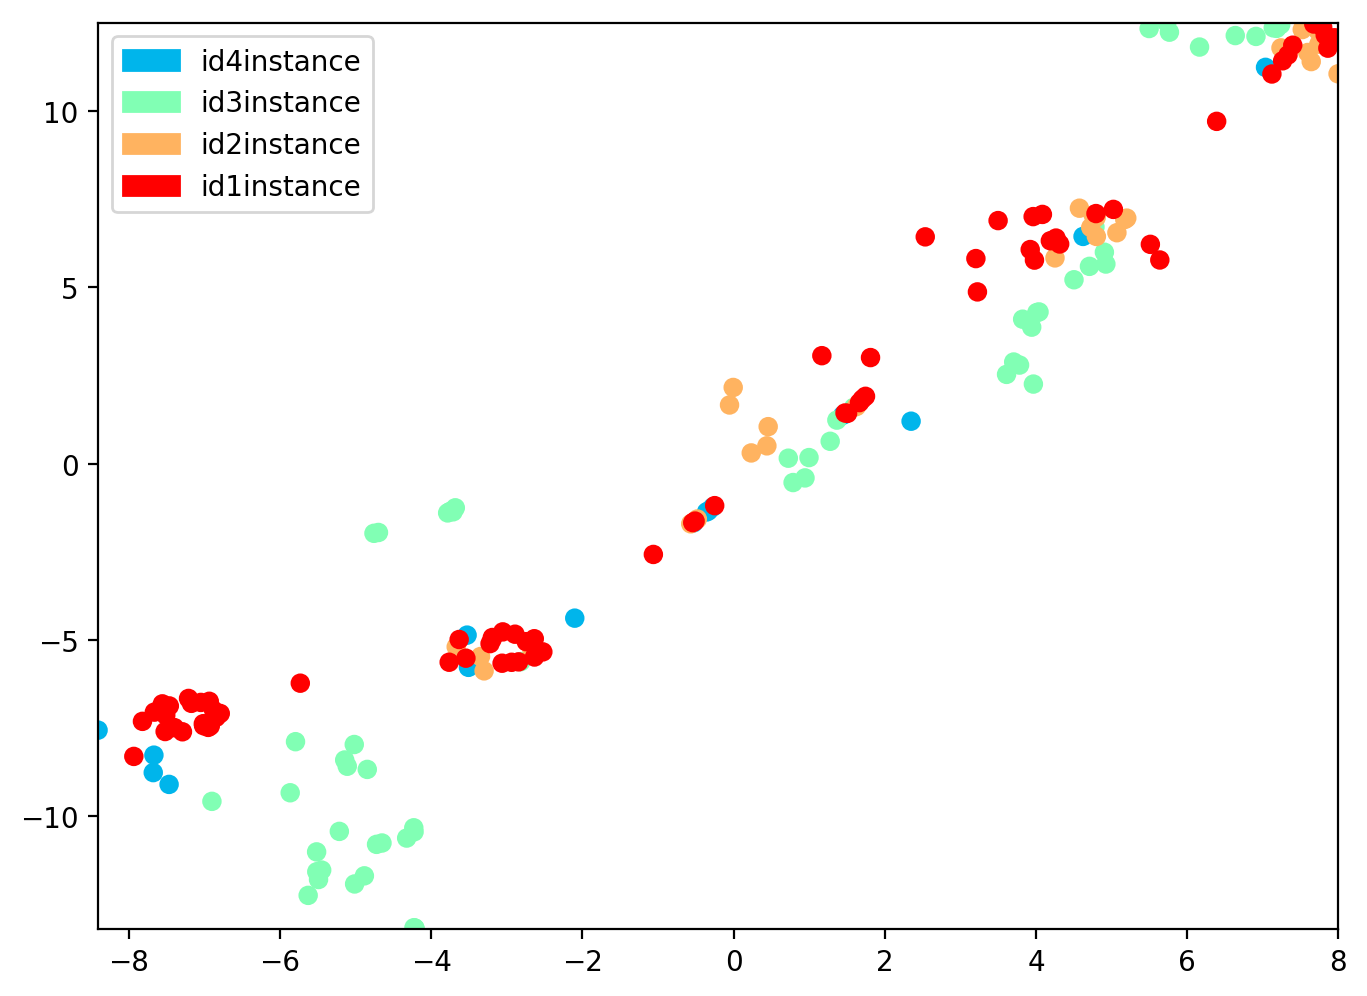

In [99]:
tsnescatterplot(subset_embeddings, subset_labels, label_enum)